In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('./Data/train.csv')
train.head()

,id,demand,date,temp_1,temp_night_1,wind_1,wind_night_1,ssrd_ratio_1,temp_2,temp_night_2,...,temp_12,temp_night_12,wind_12,wind_night_12,ssrd_ratio_12,temp_13,temp_night_13,wind_13,wind_night_13,ssrd_ratio_13
0,2,248.551330,2009-01-01,0.493500,-0.024375,2.337942,0.960386,0.834858,-0.324375,-0.064167,...,-2.363625,-0.754208,1.748286,0.438337,1.240712,-2.409958,-0.800167,2.200373,0.762233,0.915315
1,3,242.671902,2009-01-02,0.707125,-0.772042,3.241219,0.933666,1.585796,1.011167,-0.496917,...,-0.279708,-0.677500,1.826779,0.590232,1.514933,-0.316625,-0.612000,3.044197,0.997103,1.165282
2,4,251.157507,2009-01-03,-1.296292,-1.071583,2.420432,1.173104,1.424222,-0.819917,-0.821917,...,-1.832542,-1.051208,1.238009,0.766633,1.572659,-3.518542,-1.978167,1.580882,0.578175,1.793391
3,5,260.073426,2009-01-04,-0.899583,-0.257417,3.756638,1.464167,1.067949,-0.197667,0.194583,...,-0.315917,-0.044708,2.237830,0.961864,0.613913,-1.496042,-0.720583,2.173770,0.862646,0.792718
4,6,277.125461,2009-01-05,-0.905250,-1.125292,4.416067,1.288584,1.503319,-0.249708,-0.721083,...,-1.375833,-1.417083,2.134971,0.617133,1.443376,-1.569000,-1.572250,3.726705,1.006098,1.227480


# Method 1: Brute Force

Without taking a second glance at the data, one can determine the features which correlate most strongly with demand, and fit a linear model using them.

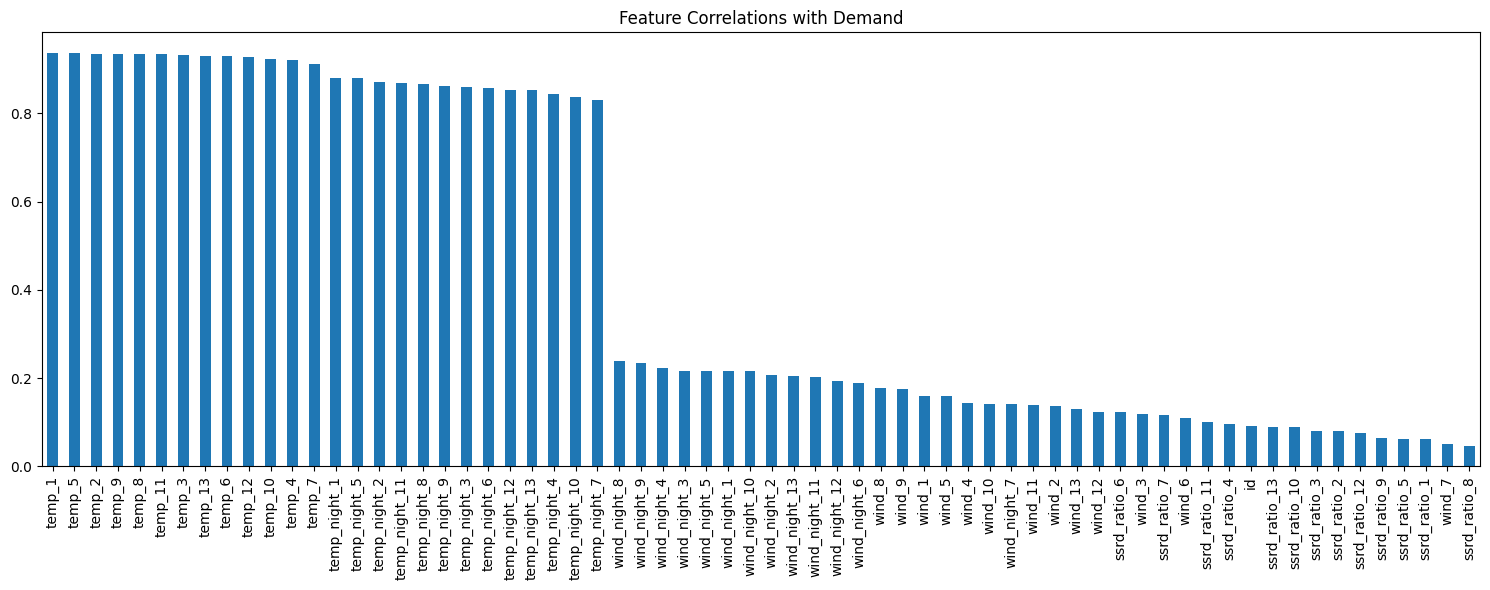

In [3]:
correlations = train.drop(columns=['demand', 'date']).corrwith(train['demand']).abs()
correlations = correlations.sort_values(ascending=False)

correlations.plot(kind='bar', figsize=(15,6))
plt.title('Feature Correlations with Demand')
plt.tight_layout()

In [4]:
high_corr_features = correlations[correlations > 0.8].index.tolist()
print(f"Features with correlation > 0.8: {len(high_corr_features)}")

Features with correlation > 0.8: 26


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split the data using train_test_split
X = train[high_corr_features]
y = train['demand']

# You can adjust test_size as needed (0.5 mimics your original 50-50 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

# Train the model
bf_model = LinearRegression()
bf_model.fit(X_train, y_train)

# Predict
y_train_pred = bf_model.predict(X_train)
y_val_pred = bf_model.predict(X_val)

# Evaluate
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Print results
print(f"\nTraining R-squared: {train_r2:.4f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Validation R-squared: {val_r2:.4f}")
print(f"Validation RMSE: {val_rmse:.2f}")



Training R-squared: 0.9346
Training RMSE: 17.67
Validation R-squared: 0.9245
Validation RMSE: 18.10


We can do better.

# Method 2: Gradient Boosted Regressor

First we look through the data. From before, we saw that the temperatures have the highest correlation with demand. How does this correlation look? What are the temperature distributions?

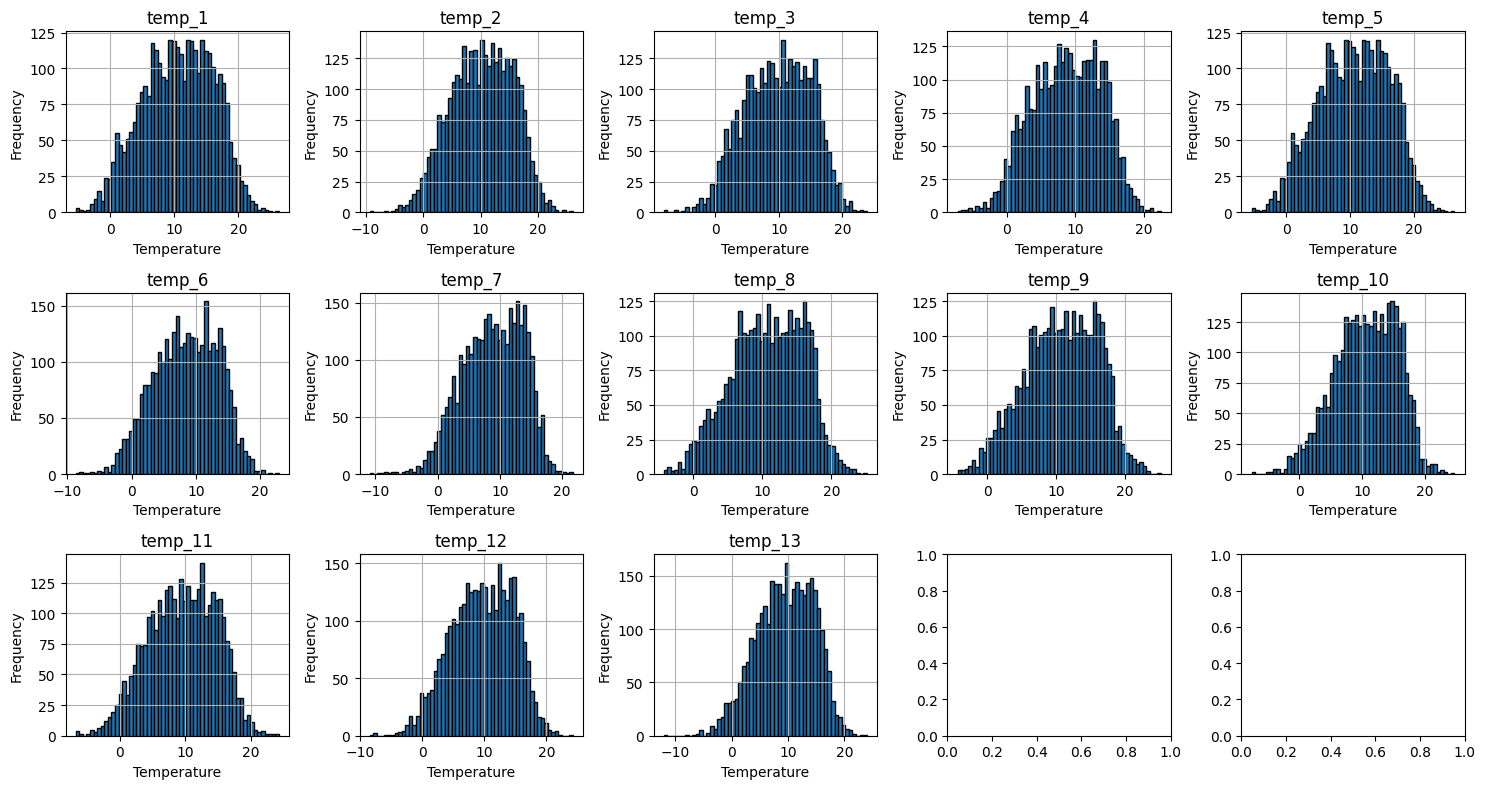

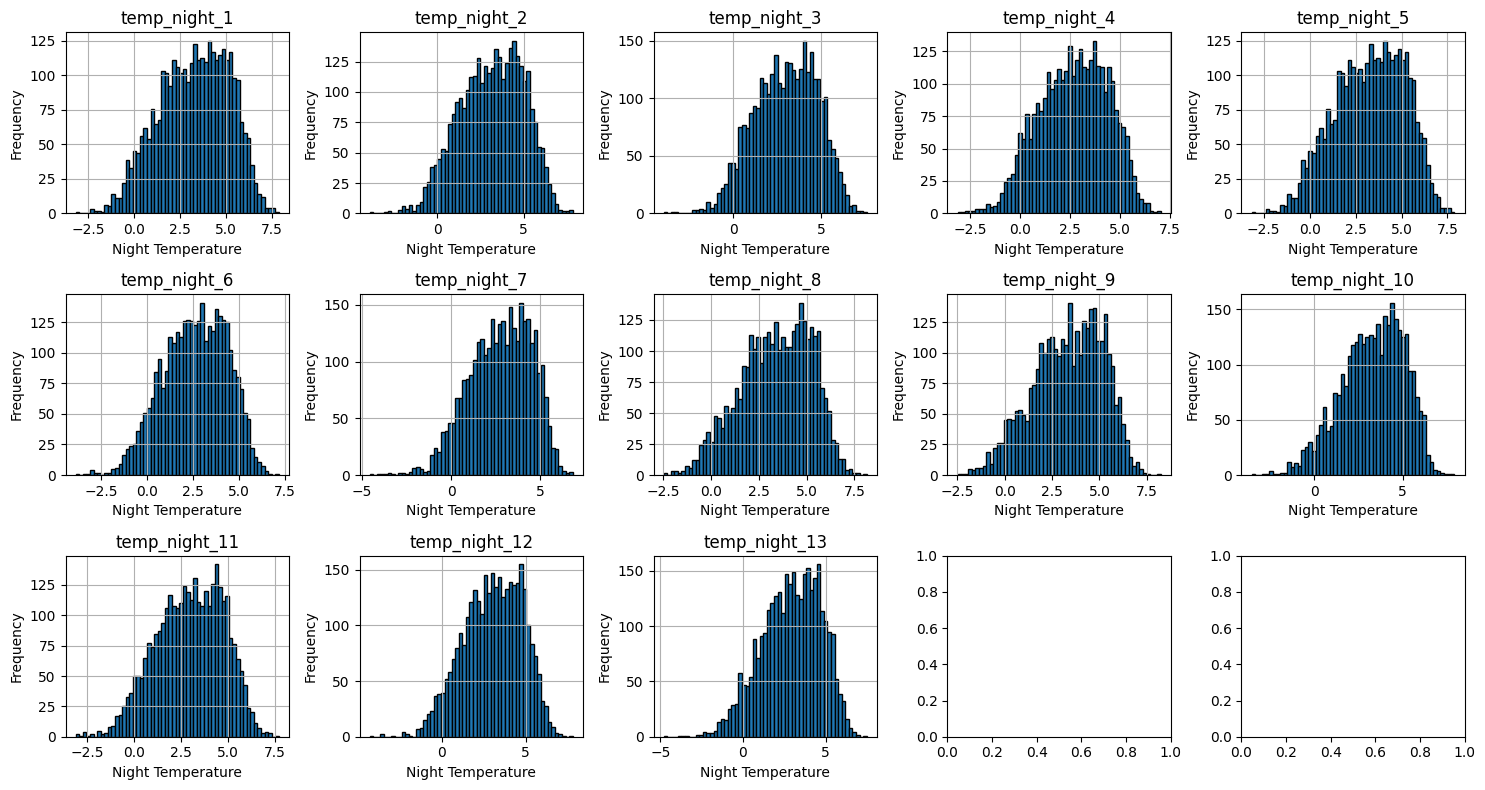

In [7]:
import math

bin_num = int(math.sqrt(len(train['temp_1'])))

temp_cols = [f'temp_{i}' for i in range(1, 14)]
temp_night_cols = [f'temp_night_{i}' for i in range(1, 14)]

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 8))
axes = axes.flatten() 

for i, col in enumerate(temp_cols):
    train[col].hist(ax=axes[i], bins=bin_num, edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Temperature')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()

fig_2, axes_2 = plt.subplots(nrows=3, ncols=5, figsize=(15, 8))
axes_2 = axes_2.flatten()  

for i, col in enumerate(temp_night_cols):
    train[col].hist(ax=axes_2[i], bins=bin_num, edgecolor='black')
    axes_2[i].set_title(col)
    axes_2[i].set_xlabel('Night Temperature')
    axes_2[i].set_ylabel('Frequency')
plt.tight_layout()

plt.show()

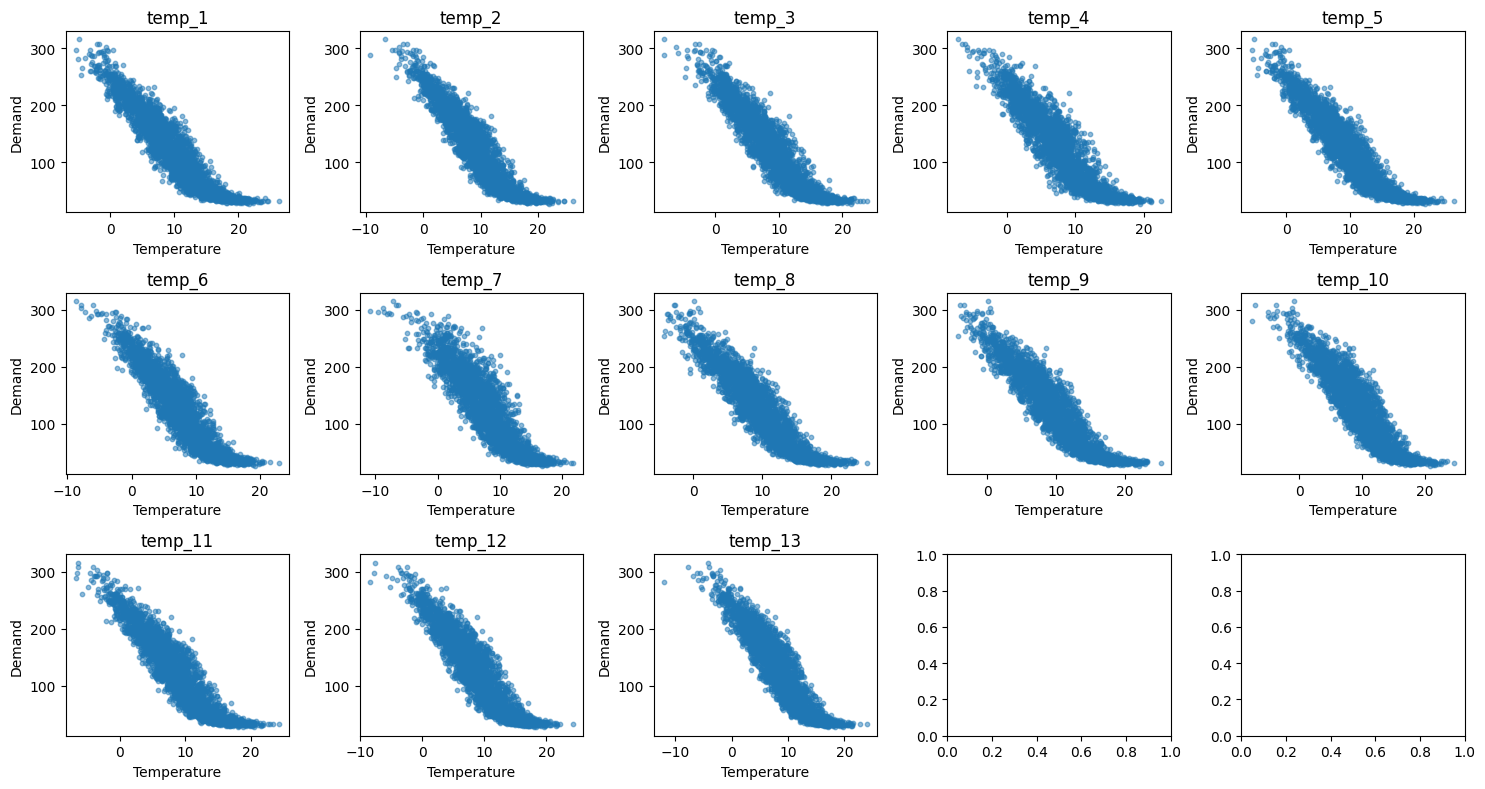

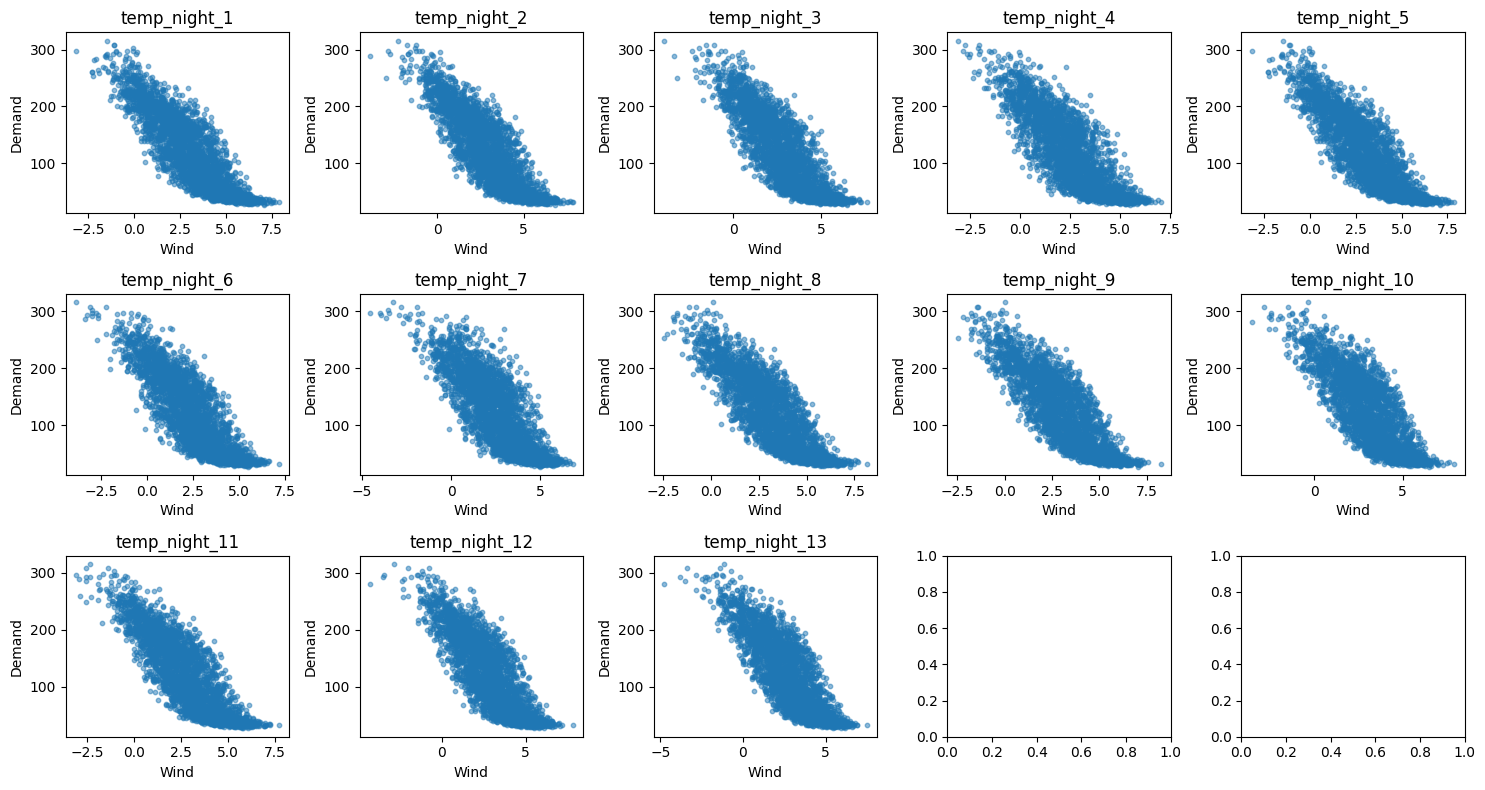

In [8]:
fig_3, axes_3 = plt.subplots(nrows=3, ncols=5, figsize=(15, 8))
axes_3 = axes_3.flatten()

for i, col in enumerate(temp_cols):
    axes_3[i].scatter(train[col], train['demand'], alpha=0.5, s=10)
    axes_3[i].set_title(col)
    axes_3[i].set_xlabel('Temperature')
    axes_3[i].set_ylabel('Demand')

plt.tight_layout()

#ratio_cols = [f'ssrd_ratio_{i}' for i in range(1, 14)]

fig_5, axes_5 = plt.subplots(nrows=3, ncols=5, figsize=(15, 8))
axes_5 = axes_5.flatten()

for i, col in enumerate(temp_night_cols):
    axes_5[i].scatter(train[col], train['demand'], alpha=0.5, s=10)
    axes_5[i].set_title(col)
    axes_5[i].set_xlabel('Wind')
    axes_5[i].set_ylabel('Demand')

plt.tight_layout()

plt.show()

The temperatures follow a nonlinear relationship with demand. A gradient boosted regressor will fit better to this data without needing much data scaling: 

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

temp_cols = [f'temp_{i}' for i in range(1, 14)] + [f'temp_night_{i}' for i in range(1, 14)]

X = train[temp_cols]
y = train['demand']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.8,
    random_state=42,
    verbose=0
)

gb_model.fit(X_train, y_train)

y_train_pred = gb_model.predict(X_train)
y_val_pred = gb_model.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R-squared: {train_r2:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation R-squared: {val_r2:.4f}")


Train RMSE: 3.4119
Train R-squared: 0.9976
Validation RMSE: 14.5234
Validation R-squared: 0.9514


### Note:
Severe gap between Train and Validation metrics, which suggests overfitting. We need to find a way to the model generalise better.

I live in the UK, so I know that when it's cold AND windy the weather will feel much harsher. Also, wind is a great heat dissipator, so I expect housing to use more gas when it's both cold and windy.

For this I consider the windchill temperature, given by the following formula:

$$ T_{WC} = 13.2 + 0.6215 \times T_{a} - 11.37 \times v^{0.16} + 0.3965 \times T_{a} \times v^{0.16} $$

Where:
- $T_{WC}$ is windchill index based on celsius
- $v$ is wind velocity in km/h
- $T_{a}$ is the wind temperature in degrees celsius

In [44]:
wind_cols = [f'wind_{i}' for i in range(1, 14)]
wind_night_cols = [f'wind_night_{i}' for i in range(1, 14)]

for i in range(1, 14): #first convert windspeed to km/h
    train[f'wind_kmh_{i}'] = train[f'wind_{i}'] * 3.6
    train[f'wind_night_kmh_{i}'] = train[f'wind_night_{i}'] * 3.6

for i in range(1, 14):
    T_a = train[f'temp_{i}']
    v = train[f'wind_kmh_{i}']
    train[f'windchill_{i}'] = 13.12 + 0.6215 * T_a + (0.3965 * T_a - 11.37) * (v ** 0.16)
    
    T_a_night = train[f'temp_night_{i}']
    v_night = train[f'wind_night_kmh_{i}']
    train[f'windchill_night_{i}'] = 13.12 + 0.6215 * T_a_night + (0.3965 * T_a_night - 11.37) * (v_night ** 0.16)

print("\nSample values:")
print(train[['wind_kmh_2', 'windchill_2', 'wind_night_kmh_2', 'windchill_night_2']].head(10))


Sample values:
   wind_kmh_2  windchill_2  wind_night_kmh_2  windchill_night_2
0    7.200600    -2.851338          3.437316          -0.804253
1    9.584390    -1.999372          2.570246          -0.641790
2    9.955315    -4.282028          5.238689          -2.635171
3   13.912641    -4.448589          5.935244          -1.775045
4   12.518110    -4.219504          3.431148          -1.525804
5    9.389832    -5.394622          4.690253          -1.787814
6    7.675047    -0.358829          2.860094           0.316078
7    7.633976     0.455392          2.868025           0.535537
8    8.863290    -4.206246          3.673108          -1.976827
9   22.419252    -5.380134          9.804315          -2.353598


Quick sanity check:

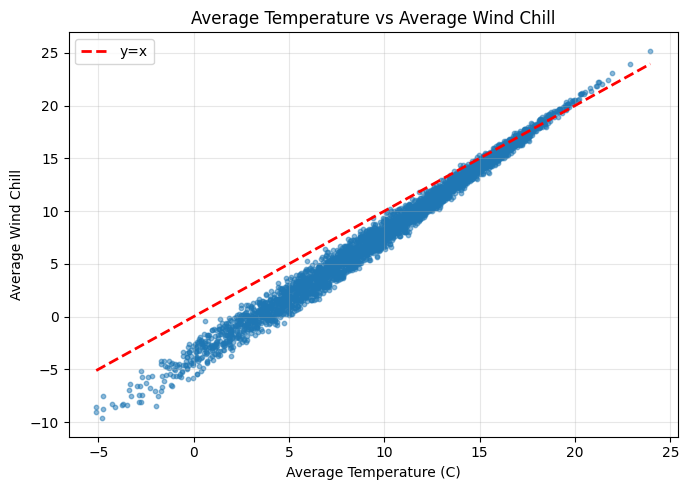


Correlation of avg wind chill with demand: -0.9495
Correlation of avg temperature with demand: -0.9441


In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

windchill_cols = [f'windchill_{i}' for i in range(1, 14)]
train['avg_windchill'] = train[windchill_cols].mean(axis=1)

temp_cols = [f'temp_{i}' for i in range(1, 14)]
train['avg_temp'] = train[temp_cols].mean(axis=1)

ax.scatter(train['avg_temp'], train['avg_windchill'], alpha=0.5, s=10)
ax.plot([train['avg_temp'].min(), train['avg_temp'].max()], 
        [train['avg_temp'].min(), train['avg_temp'].max()], 'r--', lw=2, label='y=x')
ax.set_xlabel('Average Temperature (C)')
ax.set_ylabel('Average Wind Chill')
ax.set_title('Average Temperature vs Average Wind Chill')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCorrelation of avg wind chill with demand: {train['avg_windchill'].corr(train['demand']):.4f}")
print(f"Correlation of avg temperature with demand: {train['avg_temp'].corr(train['demand']):.4f}")


We could brute force it again, bit this will yield overfitting on training set:

In [24]:
all_feature_cols = (
    [f'temp_{i}' for i in range(1, 14)] + 
    [f'temp_night_{i}' for i in range(1, 14)] +
    [f'wind_{i}' for i in range(1, 14)] + 
    [f'wind_night_{i}' for i in range(1, 14)] +
    [f'ssrd_ratio_{i}' for i in range(1, 14)] +
    [f'windchill_{i}' for i in range(1, 14)] + 
    [f'windchill_night_{i}' for i in range(1, 14)]
)

X = train[all_feature_cols]
y = train['demand']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

# Train model
model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.7,
    random_state=42
)

model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

print(f"\nTrain R2: {r2_score(y_train, y_train_pred):.4f}")
#print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")

print(f"Validation R2: {r2_score(y_val, y_val_pred):.4f}")
#print(f"Validation MSE: {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")


Train R2: 0.9952
Train RMSE: 4.8052
Validation R2: 0.9617
Validation RMSE: 12.8903



Total Importance by Feature Type:
type
wind    0.907271
temp    0.073323
ssrd    0.019406
Name: importance, dtype: float64

Top 20 Most Important Features:
         feature  importance  type
69   windchill_5    0.221722  wind
65   windchill_1    0.203406  wind
72   windchill_8    0.166732  wind
73   windchill_9    0.125641  wind
66   windchill_2    0.087759  wind
75  windchill_11    0.031099  wind
71   windchill_7    0.023699  wind
1         temp_2    0.018496  temp
8         temp_9    0.009617  temp
70   windchill_6    0.009541  wind
67   windchill_3    0.009074  wind
7         temp_8    0.006502  temp
77  windchill_13    0.006327  wind
58  ssrd_ratio_7    0.004535  ssrd
6         temp_7    0.004493  temp
0         temp_1    0.004443  temp
2         temp_3    0.003546  temp
76  windchill_12    0.003499  wind
4         temp_5    0.003470  temp
74  windchill_10    0.003359  wind


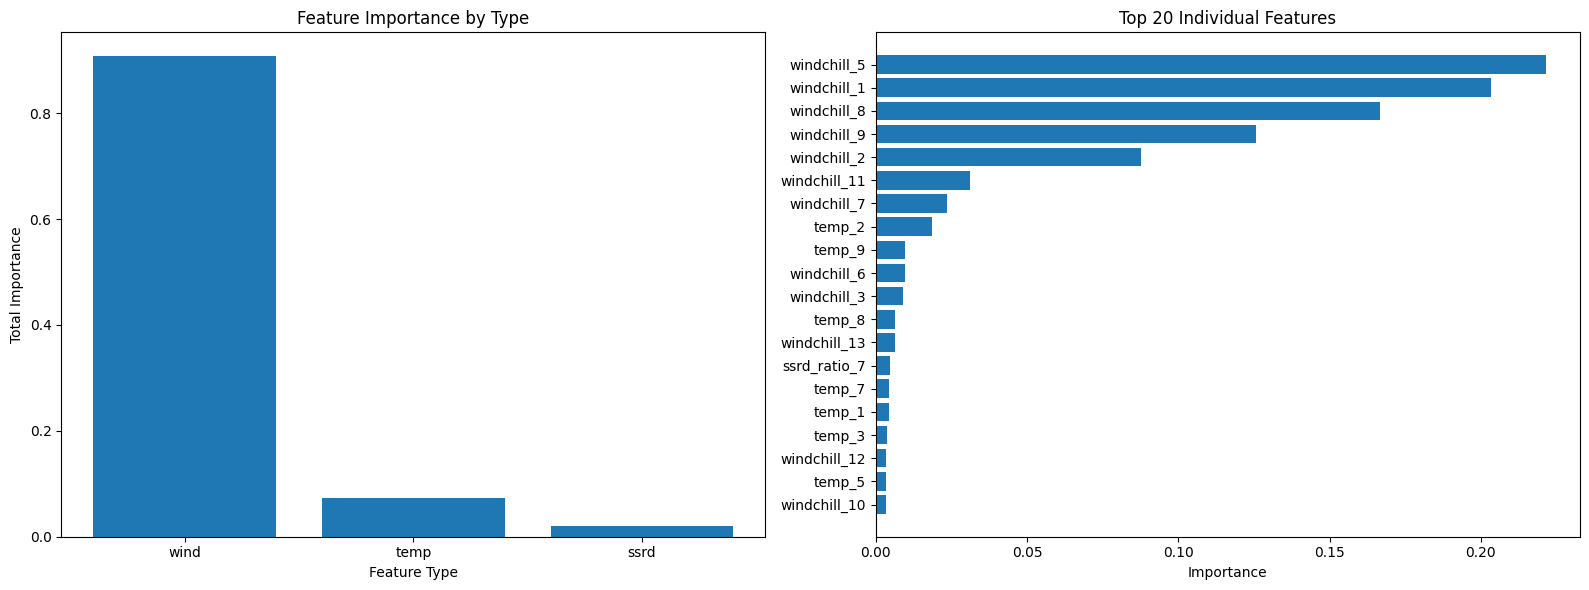

In [28]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': all_feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Group by feature type
feature_importance['type'] = feature_importance['feature'].str.extract('(temp|wind|ssrd)')[0]
importance_by_type = feature_importance.groupby('type')['importance'].sum().sort_values(ascending=False)

print("\nTotal Importance by Feature Type:")
print(importance_by_type)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By type
axes[0].bar(importance_by_type.index, importance_by_type.values)
axes[0].set_xlabel('Feature Type')
axes[0].set_ylabel('Total Importance')
axes[0].set_title('Feature Importance by Type')

# Top individual features
top_20 = feature_importance.head(20)
axes[1].barh(range(len(top_20)), top_20['importance'])
axes[1].set_yticks(range(len(top_20)))
axes[1].set_yticklabels(top_20['feature'])
axes[1].set_xlabel('Importance')
axes[1].set_title('Top 20 Individual Features')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

Seems like our new feature is quite effective! Let's try using a simpler model to close the train-val gap:

In [27]:
model_regularized = GradientBoostingRegressor(
    n_estimators=150,          # Reduced from 200
    learning_rate=0.03,        # Reduced from 0.05 (slower learning)
    max_depth=3,               # Reduced from 5 (shallower trees)
    min_samples_split=50,      # Increased from 20 (more conservative)
    min_samples_leaf=20,       # Increased from 10 (larger leaves)
    subsample=0.6,             # Reduced from 0.7 (more randomness)
    max_features='sqrt',       # Use only sqrt(n) features per split
    random_state=42,
    verbose=0
)

model_regularized.fit(X_train, y_train)

y_train_pred_reg = model_regularized.predict(X_train)
y_val_pred_reg = model_regularized.predict(X_val)

train_r2_reg = r2_score(y_train, y_train_pred_reg)
train_rmse_reg = np.sqrt(mean_squared_error(y_train, y_train_pred_reg))
val_r2_reg = r2_score(y_val, y_val_pred_reg)
val_rmse_reg = np.sqrt(mean_squared_error(y_val, y_val_pred_reg))

print(f"Train R2:      {train_r2_reg:.4f}")
print(f"Train RMSE:    {train_rmse_reg:.2f}")
print(f"Val R2:        {val_r2_reg:.4f}")
print(f"Val RMSE:      {val_rmse_reg:.2f}")

print(f"\nOverfit Gap:   {train_r2_reg - val_r2_reg:.4f}")
print(f"RMSE Ratio:    {val_rmse_reg/train_rmse_reg:.2f}x")

Train R2:      0.9681
Train RMSE:    12.35
Val R2:        0.9514
Val RMSE:      14.52

Overfit Gap:   0.0166
RMSE Ratio:    1.18x


Why is this model better than the first gradient boosted regressor we fit? It should generalise better to unseen data since it isn't overfitting to the training set as heavily. This improvement is partly due to the regularisation techniques, which help prevent the model from fitting noise, and the new feature. Overall model performance metrics below:

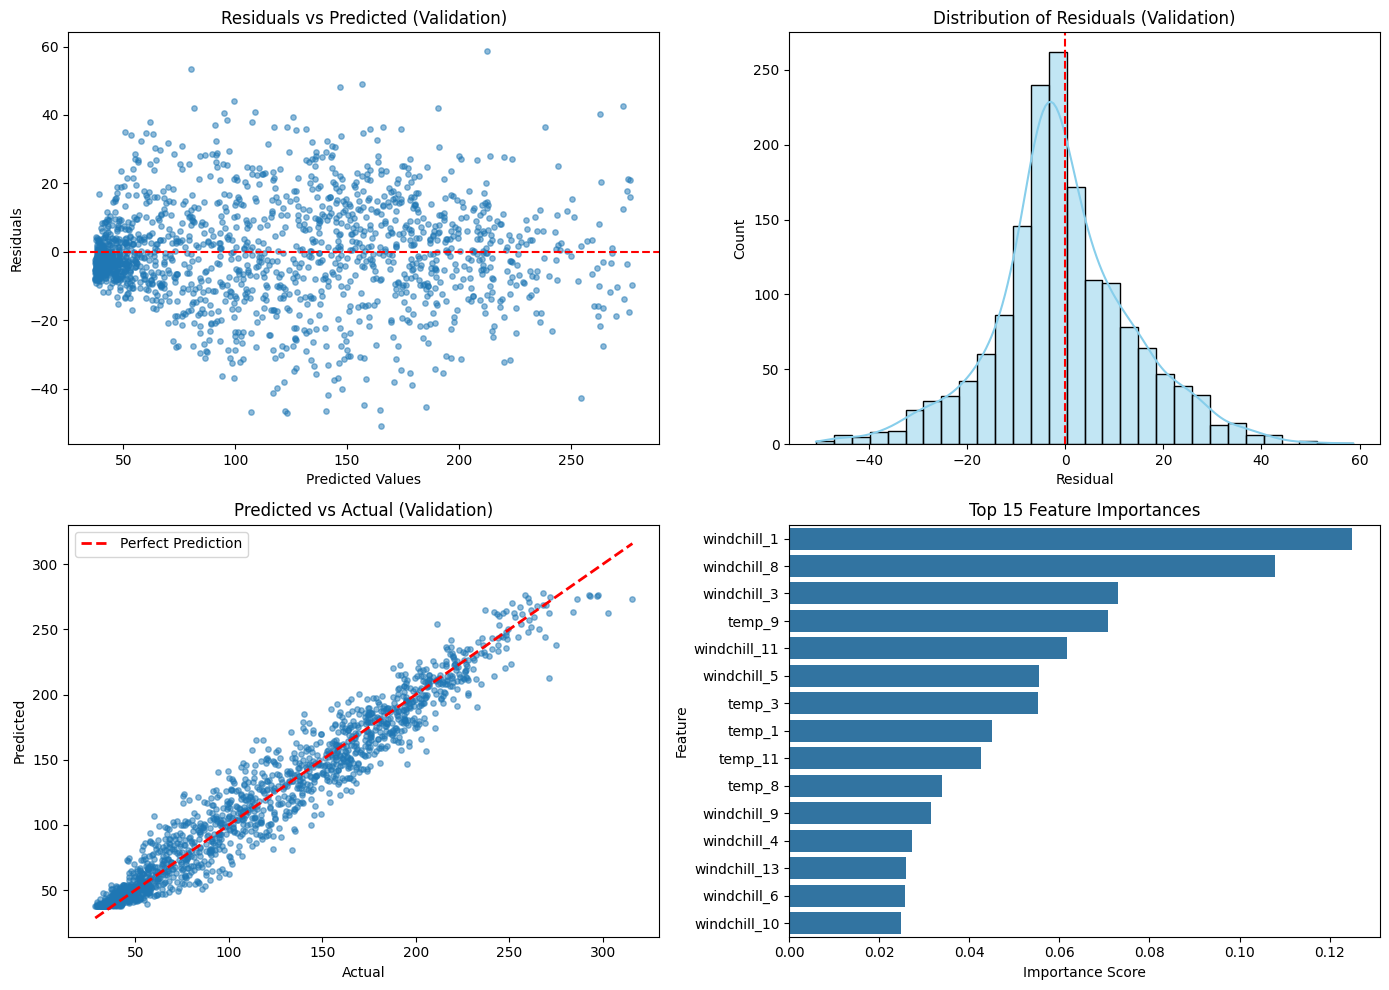

In [ ]:
import seaborn as sns

residuals_val = y_val - y_val_pred_reg
residuals_train = y_train - y_train_pred_reg

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

axes[0, 0].scatter(y_val_pred_reg, residuals_val, alpha=0.5, s=15)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title("Residuals vs Predicted (Validation)")
axes[0, 0].set_xlabel("Predicted Values")
axes[0, 0].set_ylabel("Residuals")

sns.histplot(residuals_val, bins=30, kde=True, ax=axes[0, 1], color='skyblue')
axes[0, 1].axvline(0, color='red', linestyle='--')
axes[0, 1].set_title("Distribution of Residuals (Validation)")
axes[0, 1].set_xlabel("Residual")

axes[1, 0].scatter(y_val, y_val_pred_reg, alpha=0.5, s=15)
axes[1, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1, 0].set_title("Predicted vs Actual (Validation)")
axes[1, 0].set_xlabel("Actual")
axes[1, 0].set_ylabel("Predicted")
axes[1, 0].legend()

feature_importance = pd.Series(model_regularized.feature_importances_, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False).head(15)  # Top 15
sns.barplot(x=feature_importance.values, y=feature_importance.index, ax=axes[1, 1])
axes[1, 1].set_title("Top 15 Feature Importances")
axes[1, 1].set_xlabel("Importance Score")
axes[1, 1].set_ylabel("Feature")

plt.tight_layout()
plt.show()

It's nice to confirm that our windchill features remain relevant in this simpler model.

In [38]:
test = pd.read_csv('./Data/test.csv')
test.head()

,id,date,temp_1,temp_night_1,wind_1,wind_night_1,ssrd_ratio_1,temp_2,temp_night_2,wind_2,...,temp_12,temp_night_12,wind_12,wind_night_12,ssrd_ratio_12,temp_13,temp_night_13,wind_13,wind_night_13,ssrd_ratio_13
0,3289,2018-01-01,5.585208,1.993833,6.186903,2.687792,0.986323,5.480292,1.860458,6.289224,...,5.414625,1.751167,5.319593,1.743017,1.519060,5.269542,1.620917,5.583635,1.712075,1.480541
1,3290,2018-01-02,7.299708,3.047417,7.304455,3.489781,0.325592,6.497458,2.699792,7.298662,...,6.716708,2.402708,6.134415,2.722164,0.469433,7.306375,2.515708,6.971262,2.972217,0.415229
2,3291,2018-01-03,7.480708,2.393500,9.116166,2.729530,1.292505,7.725583,2.637750,9.317749,...,7.483250,2.572125,7.073263,2.146690,1.225938,6.883917,2.259542,6.909641,1.967227,1.553210
3,3292,2018-01-04,7.068500,2.045583,6.344000,1.467153,0.570070,5.922167,1.509625,6.090639,...,5.605083,1.394917,4.918405,0.857545,0.888301,6.452083,1.735833,5.871079,1.027200,1.015007
4,3293,2018-01-05,4.458708,0.857667,4.177804,0.719279,1.527976,3.002167,0.377917,2.531515,...,2.003125,0.390792,1.896462,0.657776,0.762359,2.236458,0.072667,3.182478,0.957821,1.048007


In [43]:
for i in range(1, 14): #first convert windspeed to km/h
    test[f'wind_kmh_{i}'] = test[f'wind_{i}'] * 3.6
    test[f'wind_night_kmh_{i}'] = test[f'wind_night_{i}'] * 3.6

for i in range(1, 14):
    T_a = test[f'temp_{i}']
    v = test[f'wind_kmh_{i}']
    test[f'windchill_{i}'] = 13.12 + 0.6215 * T_a + (0.3965 * T_a - 11.37) * (v ** 0.16)
    
    T_a_night = test[f'temp_night_{i}']
    v_night = test[f'wind_night_kmh_{i}']
    test[f'windchill_night_{i}'] = 13.12 + 0.6215 * T_a_night + (0.3965 * T_a_night - 11.37) * (v_night ** 0.16)

print("\nSample values:")
print(test[['wind_kmh_2', 'windchill_2', 'wind_night_kmh_2', 'windchill_night_2']].head())


Sample values:
   wind_kmh_2  windchill_2  wind_night_kmh_2  windchill_night_2
0   22.641208     1.375285          8.918968          -0.813360
1   26.275185     2.322683         12.384935          -0.607747
2   33.543895     3.349011         10.610561          -0.305727
3   21.926299     2.014631          5.111083           0.074098
4    9.113454     0.488726          2.767212           0.150262


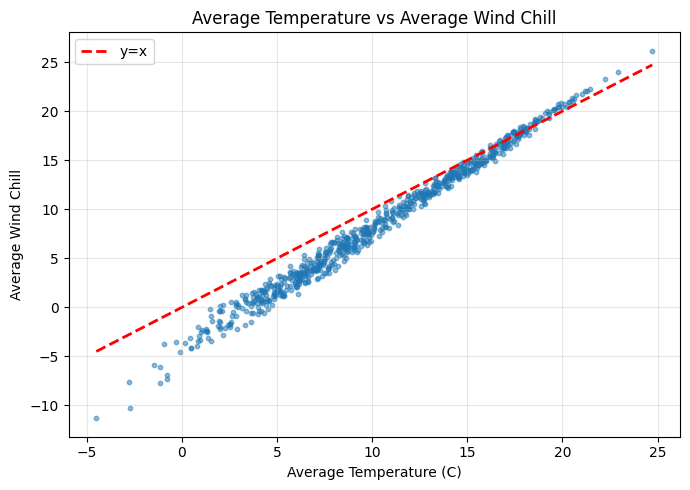

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

windchill_cols = [f'windchill_{i}' for i in range(1, 14)]
test['avg_windchill'] = test[windchill_cols].mean(axis=1)

temp_cols = [f'temp_{i}' for i in range(1, 14)]
test['avg_temp'] = test[temp_cols].mean(axis=1)

ax.scatter(test['avg_temp'], test['avg_windchill'], alpha=0.5, s=10)
ax.plot([test['avg_temp'].min(), test['avg_temp'].max()], 
        [test['avg_temp'].min(), test['avg_temp'].max()], 'r--', lw=2, label='y=x')
ax.set_xlabel('Average Temperature (C)')
ax.set_ylabel('Average Wind Chill')
ax.set_title('Average Temperature vs Average Wind Chill')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

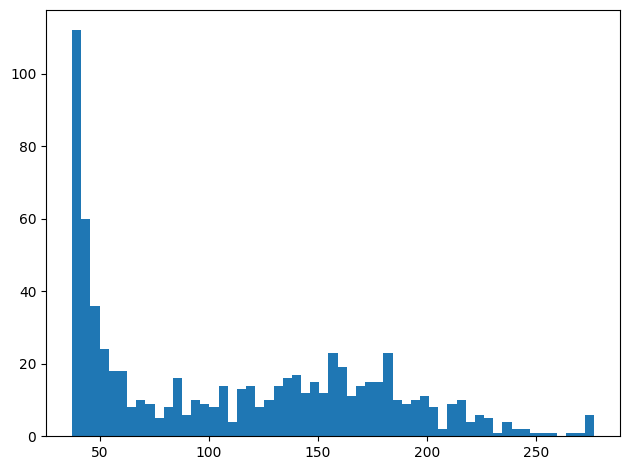

In [61]:
target_feature_cols = (
    [f'temp_{i}' for i in range(1, 14)] + 
    [f'temp_night_{i}' for i in range(1, 14)] +
    [f'wind_{i}' for i in range(1, 14)] + 
    [f'wind_night_{i}' for i in range(1, 14)] +
    [f'ssrd_ratio_{i}' for i in range(1, 14)] +
    [f'windchill_{i}' for i in range(1, 14)] + 
    [f'windchill_night_{i}' for i in range(1, 14)]
)

final = test[target_feature_cols]
preds = model_regularized.predict(final)
plt.hist(preds, bins=bin_num)
plt.tight_layout()

In [62]:
submission = pd.DataFrame({
    'id': test['id'],
    'demand': preds
})

submission.to_csv('submission.csv', index=False)
print(f"Submission file created with {len(submission)} predictions")
print(submission.head())

Submission file created with 730 predictions
     id      demand
0  3289  179.900973
1  3290  183.993152
2  3291  168.538646
3  3292  174.052569
4  3293  196.512869


# Future work:

I didn't take into consideration temporal factors. A more robust model could implement a correlation feature between temperatures of adjacent days to include seasonal patterns. 

For UK domestic gas demand:

- Seasonal heating patterns
- Working day vs. weekend effects
- Holiday impacts
- Lag effects (previous days' weather/demand)